# Code

In [1]:
%load_ext autoreload

In [2]:
from plot_setup import * 
import MCgenerator, dSph_model, coord
from numpy import power,sqrt
from scipy.stats import norm

In [3]:
%autoreload 2

In [4]:
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [280]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
# v001: for mycut
# v002: for spectroscopy cut

## definition of likelihood

In [359]:
class KI17_loglikelihood_mod_cont:
    def __init__(self,vs,beta=1):
        self.vs = vs
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args))
    
    def is_parameters_in_domain(self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 < vfg1 < vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_not_fast)
    
    def loglikelis(
        self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            sfg2 = 1-sfg0-sfg1
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(ffg)

            return self.beta * ret
        
    def fit_plot(self,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1,bins=64,**kwargs):
        fig,ax = plt.subplots(1,1)
        vs=self.vs
        sfg2 = 1-sfg0-sfg1 
        ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
        ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
        ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
        ffg = ffg0+ffg1+ffg2
        df = pd.DataFrame()
        df[r"$v$"] = vs
        df["$f_{FG,0}$"] = ffg0
        df["$f_{FG,1}$"] = ffg1
        df["$f_{FG,2}$"] = ffg2
        df["$f_{FG,tot}$"] = ffg
        
        df = df.sort_values(r"$v$")
        
        ax.hist(vs,density=True,bins=bins)
        df.plot(x=r"$v$",ax=ax,**kwargs)


In [68]:
#update likelihood
def is_positive(*args):
    return np.array(args)>0

class KI17_loglikelihood_mod:
    def __init__(self,vs,dRAs,dDEs,beta=1):
        self.vs = vs
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        mem = dSph_model.plummer_model(re_pc=200)
        dm = dSph_model.NFW_model(a=2.78,b=7.78,g=0.675,rhos_Msunpc3=np.power(10,-2.05),rs_pc=np.power(10,3.96),R_trunc_pc=2000)
        self.dsph = dSph_model.dSph_model(anib=-0.5,submodels_dict={"stellar_model":mem,"DM_model":dm},show_init=True)
        
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R,show_init=True)


    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args))
    
    def is_parameters_in_domain(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(re,odds,dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 < vfg1 < vfg2
        is_ffg_normalized_ = 0<sfg0<1 and 0<sfg1<1 and (sfg0+sfg1)<1
        is_in_domain_ = -1<mlog10_1manib<1 and -4<log10_rhos_Msunpc3<4 and 0<log10_rs_pc<5 and 0.5<a<3,3<b<10,0<g<1.2
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_in_domain_)
    
    def loglikelis(
        self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(re,odds,dra0,dde0,
                log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
                mlog10_1manib,
                vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            mem,dm,fg = self.dsph.submodels["stellar_model"],self.dsph.submodels["DM_model"],self.fg
            mem.update({"re_pc":re})
            dm.update({"rs_pc":power(10,log10_rs_pc),"rhos_Msunpc3":power(10,log10_rhos_Msunpc3),"a":a,"b":b,"g":g})
            self.dsph.update({"anib":1-power(10,-mlog10_1manib)})
            ref_R = mem.half_light_radius() # 1.67834699001666*re
            
            Rs = self.Rs(dra0,dde0)
        
            s = 1/(1+ 1/(odds * mem.density_2d_normalized_re(Rs)))
            sigmalos2 = self.dsph.sigmalos2_interp1d(Rs,step_inner=8,step_outer=16)
            sfg2 = 1-sfg0-sfg1
            
            fmem = norm.pdf(vs,loc=vmem,scale=sqrt(sigmalos2))
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(s*fmem+(1-s)*ffg)

            return self.beta * ret


Text(0,0.5,'$y$[deg]')

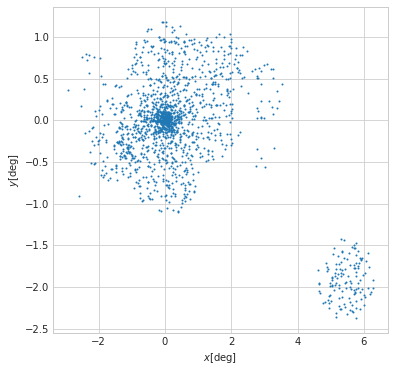

In [319]:
df0 = pd.read_csv("dra_sspp2_RADEdeg.csv")
#display(df0)
df_deg = pd.DataFrame(df0[["RAdeg","DEdeg"]])
df_rad = np.deg2rad(pd.DataFrame(df_deg))

df_deg["x"] = df_deg["RAdeg"] - RA0
df_deg["y"] = df_deg["DEdeg"] - DE0

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.RAdeg
de = df_deg.DEdeg
vs = df0.Vlos

arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 4
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))
plt.xlabel(r"$x$[deg]")
plt.ylabel(r"$y$[deg]")

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78c25df9b0>]],
      dtype=object)

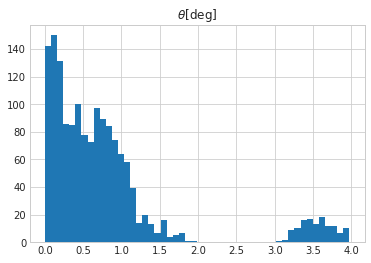

In [8]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78ba6866a0>]],
      dtype=object)

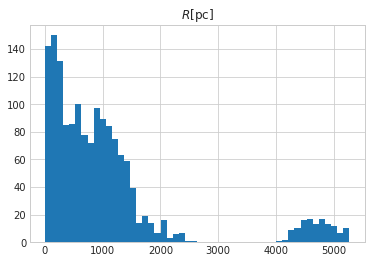

In [9]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

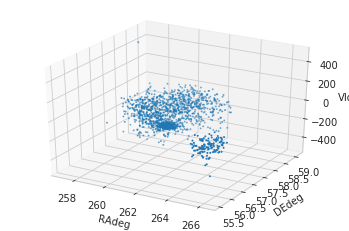

In [10]:
df0[["RAdeg","DEdeg","Vlos"]].plot_scatter3D("RAdeg","DEdeg","Vlos",s=1)

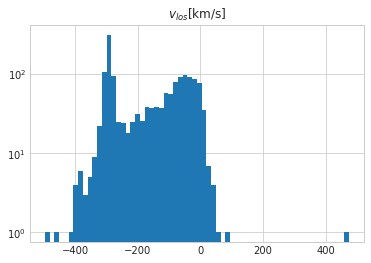

In [334]:
df_vlos = pd.DataFrame({r"$v_{los}$[km/s]":df0.Vlos.values})
df_vlos.hist(bins=64)
len(df0)
plt.yscale("log")

127

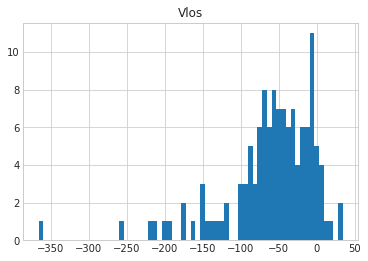

In [142]:
df_plot = df0[Rs>3000]
df_plot.hist("Vlos",bins=64)
len(df_plot)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7878324e48>]],
      dtype=object)

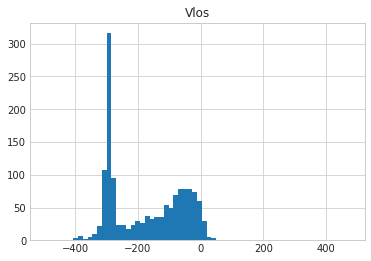

In [115]:
df0[angles<2.5].hist("Vlos",bins=64)

## likelihood compile

In [360]:
isin_sig = Rs<3000
loglikeli_cont =  KI17_loglikelihood_mod_cont(vs=vs[np.logical_not(isin_sig)])
loglikeli = KI17_loglikelihood_mod(vs=vs[isin_sig],dRAs=df_deg.x[isin_sig],dDEs=df_deg.y[isin_sig])
#sigmalos2 = loglikeli.dsph.sigmalos2_using_mykernel(loglikeli.Rs(0,0))
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

initialized:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64
initialized:
Rmax_pc    2531.745788
dtype: float64


CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.41 s


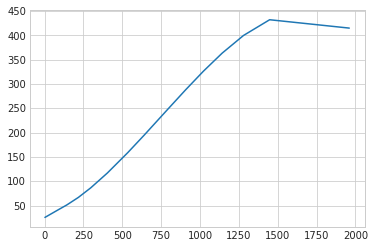

In [12]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys0 = loglikeli.dsph.sigmalos2(R_pc)
plt.plot(R_pc,ys0)

: Plummer model and NFW model:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64

2000.0

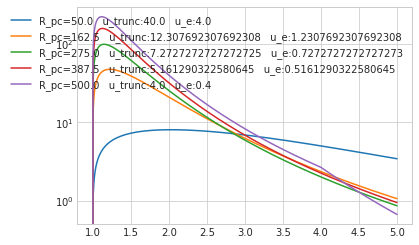

In [13]:
display(loglikeli.dsph)
us = np.linspace(1,5,1000)
for R_pc in np.linspace(50,500,5):#,100,200,1000,2000,3000,4000):
    ys = loglikeli.dsph.integrand_sigmalos2_using_mykernel(arg_R_pc=R_pc,u=us)
    R_trunc_pc= loglikeli.dsph.submodels["DM_model"].params.R_trunc_pc
    re_pc= loglikeli.dsph.submodels["stellar_model"].params.re_pc
    plt.plot(us,ys,label="R_pc="+str(R_pc)+"   u_trunc:"+str(R_trunc_pc/R_pc)+"   u_e:"+str(re_pc/R_pc))
    #display(ys)
plt.legend()
plt.xscale("linear")
plt.yscale("log")
display(R_trunc_pc)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


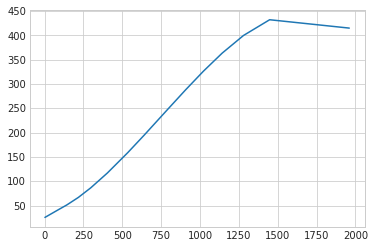

In [14]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys1 = loglikeli.dsph.sigmalos2_using_mykernel(R_pc)
plt.plot(R_pc,ys1)

CPU times: user 24 ms, sys: 44 ms, total: 68 ms
Wall time: 7.85 s


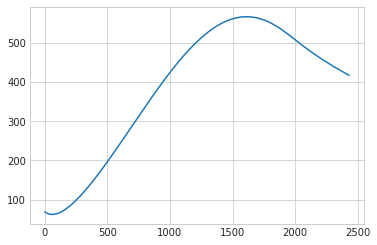

In [51]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys0 = loglikeli.dsph.sigmalos2_multi_using_mykernel(R_pc)
plt.plot(R_pc,ys0)

CPU times: user 24 ms, sys: 32 ms, total: 56 ms
Wall time: 992 ms


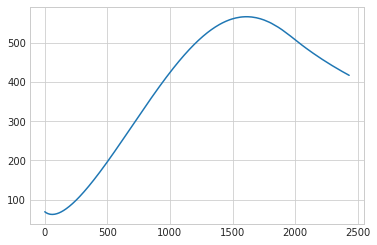

In [53]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys1 = loglikeli.dsph.sigmalos2_interp1d(R_pc,step_inner=8,step_outer=16)
plt.plot(R_pc,ys1)

1.6773225331654775

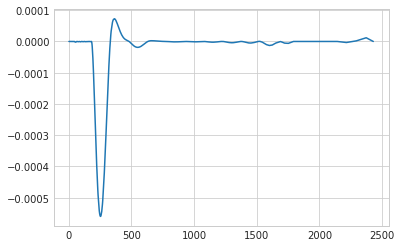

In [54]:
plt.plot(R_pc,(np.array(ys1)-np.array(ys0))/np.array(ys0))
min(R_pc)

/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:280: RuntimeWarning: divide by zero encountered in true_divide
  u2 = 1./c/c
/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:284: RuntimeWarning: divide by zero encountered in true_divide
  return sqrt(u2-1)*((1.5-anib)*u2*hyp2f1(1.0,1.5-anib,1.5,1-u2)-0.5) * self.submodels["stellar_model"].density_3d(arg_R_pc/c)*GMsun_m3s2*self.submodels["DM_model"].enclosure_mass(arg_R_pc/c)/parsec # NOTE: without u^-2 !! 1/parsec because we divide it by Sigmaast [pc^-2] so convert one of [m] -> [pc]
/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:217: RuntimeWarning: invalid value encountered in multiply
  x = power(r_pc/rs_pc,a)*is_in_Rtrunc


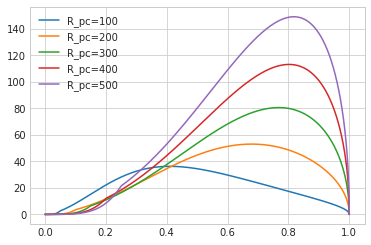

In [16]:
cs = np.linspace(0,1,10000)
for R_pc in (100,200,300,400,500):#,100,200,1000,2000,3000,4000):
    ys = loglikeli.dsph.integrand_sigmalos2(arg_R_pc=R_pc,c=cs)/loglikeli.dsph.submodels["stellar_model"].density_2d(R_pc)*1e-6
    plt.plot(cs,ys,label="R_pc="+str(R_pc))
plt.legend()

/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:280: RuntimeWarning: divide by zero encountered in true_divide
  u2 = 1./c/c
/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:284: RuntimeWarning: divide by zero encountered in true_divide
  return sqrt(u2-1)*((1.5-anib)*u2*hyp2f1(1.0,1.5-anib,1.5,1-u2)-0.5) * self.submodels["stellar_model"].density_3d(arg_R_pc/c)*GMsun_m3s2*self.submodels["DM_model"].enclosure_mass(arg_R_pc/c)/parsec # NOTE: without u^-2 !! 1/parsec because we divide it by Sigmaast [pc^-2] so convert one of [m] -> [pc]
/home/gomesu/workspace/git_code/modKI17/Draco/dSph_model.py:217: RuntimeWarning: invalid value encountered in multiply
  x = power(r_pc/rs_pc,a)*is_in_Rtrunc


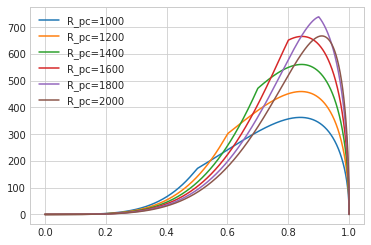

In [17]:
cs = np.linspace(0,1,100000)
for R_pc in (1000,1200,1400,1600,1800,2000):#,100,200,1000,2000,3000,4000):
    ys = loglikeli.dsph.integrand_sigmalos2(arg_R_pc=R_pc,c=cs)/loglikeli.dsph.submodels["stellar_model"].density_2d(R_pc)*1e-6
    plt.plot(cs,ys,label="R_pc="+str(R_pc))
plt.legend()

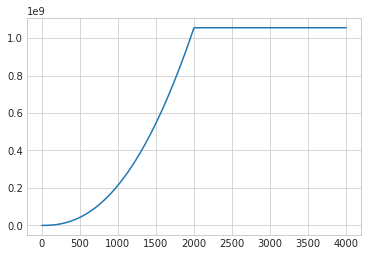

In [18]:
rs = np.linspace(0,4000,10000)
ys = loglikeli.dsph.submodels["DM_model"].enclosure_mass(rs)
plt.plot(rs,ys)


In [19]:
def integrand_check(R_pc_in,R_max_in=5000,ylim=None):
    cs = np.linspace(0+1e-10,1,100000)
    for R_pc in R_pc_in:#,100,200,1000,2000,3000,4000):
        ys = loglikeli.dsph.integrand_sigmalos2(arg_R_pc=R_pc,c=cs)/loglikeli.dsph.submodels["stellar_model"].density_2d(R_pc)*1e-6
        plt.plot(1/cs,ys,label="R_pc="+str(R_pc))
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((1,R_max_in))
    plt.ylim(ylim) if ylim!=None else None
    #plt.yscale("log")

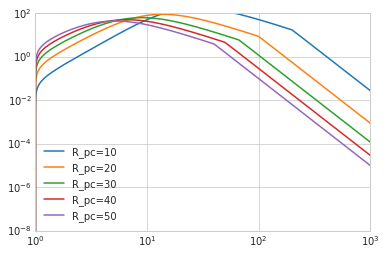

In [20]:
integrand_check((10,20,30,40,50),1e3,ylim=(1e-8,1e2))

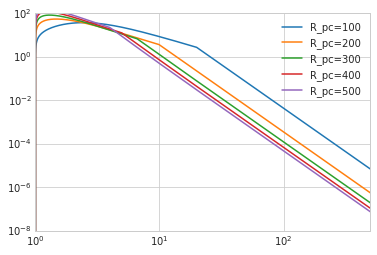

In [21]:
integrand_check((100,200,300,400,500),500,ylim=(1e-8,1e2))

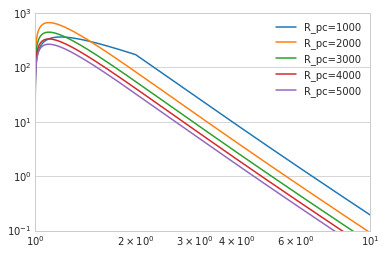

In [22]:
integrand_check((1000,2000,3000,4000,5000),10,ylim=(1e-1,1e3))

### Case: log r

In [23]:
def integrand_check_logr(R_pc_in,R_max_in=5000):
    cs = np.linspace(0+1e-10,1,100000)
    for R_pc in R_pc_in:#,100,200,1000,2000,3000,4000):
        ys = (R_pc/cs)*loglikeli.dsph.integrand_sigmalos2(arg_R_pc=R_pc,c=cs)/loglikeli.dsph.submodels["stellar_model"].density_2d(R_pc)*1e-6
        plt.plot(1/cs,ys,label="R_pc="+str(R_pc))
    plt.legend()
    plt.xscale("log")
    plt.xlim((1,R_max_in))
    #plt.yscale("log")

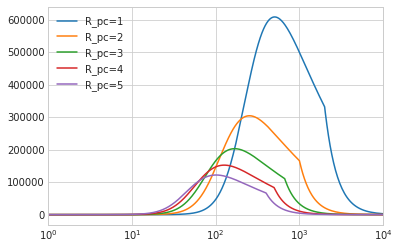

In [24]:
integrand_check_logr((1,2,3,4,5),10000)

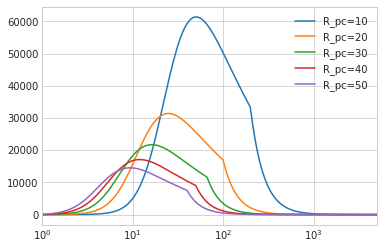

In [25]:
integrand_check_logr((10,20,30,40,50))

KeyboardInterrupt: 

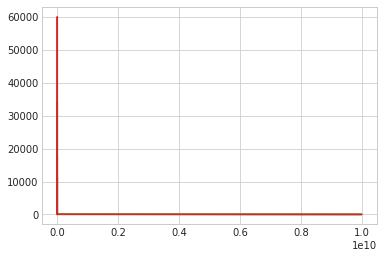

In [26]:
integrand_check_logr((100,200,300,400,500),100)

In [ ]:
integrand_check_logr((1000,2000,3000,4000,5000),10)

In [ ]:
integrand_check_logr((10,20,30,40,50))

# MCMC

## Cont

In [304]:
gen_cont = MCgenerator.MCgenerator(
    args_logpdf_init={
        "vfg0": -152.939605,
        "vfg1": -43.608103,
        "vfg2": -4.512821,
        "dvfg0": 80.441576,
        "dvfg1": 33.495326,
        "dvfg2": 0.490637,
        "sfg0":  0.183776,
        "sfg1":  0.773582},
#    args_logpdf_init={
#        'vfg0':-136, 'vfg1':-46, 'vfg2':-5, 'dvfg0':93, 'dvfg1':32,'dvfg2':0.6,
#        'sfg0':0.25,'sfg1':0.66
#    },
    dargs_logpdf={
        'vfg0':30, 'vfg1':8, 'vfg2':0.001, 'dvfg0':15, 'dvfg1':6,'dvfg2':0.001,
        'sfg0':0.05,'sfg1':0.05
    },
    logpdf_func=loglikeli_cont
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [246]:
loglikeli_cont(**{
        'vfg0':-4e8, 'vfg1':-200, 'vfg2':-0, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.01,'sfg1':0.2
    })

TypeError: loglikelis() got an unexpected keyword argument 'kwargs'

In [305]:
Nstep_init = 100000
gen_cont.generate(Nstep_init)

MCgeneration start.
options: {}
25.052% completed... acceptance rate: 7.12%
49.840% completed... acceptance rate: 7.26%
73.668% completed... acceptance rate: 7.35%
98.553% completed... acceptance rate: 7.44%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dvfg0  dvfg1  dvfg2  sfg0  sfg1  vfg0  vfg1   vfg2  iter_num
0   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000


In [308]:
#gen_cont.generate(100000)
gen_cont.generate_tuned([100000]*10)

MCgeneration start.
options: {}
25.006% completed... acceptance rate: 7.64%
49.825% completed... acceptance rate: 7.81%
74.754% completed... acceptance rate: 7.62%
99.310% completed... acceptance rate: 7.62%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dvfg0  dvfg1  dvfg2  sfg0  sfg1  vfg0  vfg1   vfg2  iter_num
0   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000
1   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000
0th iteration: update dargs_logpdf. 
before:
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64
after:
vfg0     31.123157
vfg1      4.500834
vfg2      0.017810
dvfg0    17.595276
dvfg1     3.819104
dvfg2     0.021978
sfg0      0.066832
sfg1      0.069415
dtype: float64
MCgeneration start.
options: {}
26.518% completed... acceptance rate: 8.70%
52.679% completed... acceptance rate: 8.95%
75.405% completed... acceptance rate: 8.73%
MCgeneration en

/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


MCgeneration end.
MCresults are stored.
MCinfo are logged.
        dvfg0      dvfg1      dvfg2      sfg0      sfg1        vfg0  \
0   15.000000   6.000000   0.001000  0.050000  0.050000   30.000000   
1   15.000000   6.000000   0.001000  0.050000  0.050000   30.000000   
2   17.595276   3.819104   0.021978  0.066832  0.069415   31.123157   
3   17.813542   3.847406   0.538664  0.067345  0.069992   31.667525   
4  355.601066  25.332066  12.274535  0.104043  0.243732  297.239671   

        vfg1       vfg2  iter_num  
0   8.000000   0.001000    100000  
1   8.000000   0.001000    100000  
2   4.500834   0.017810    100000  
3   4.589748   0.388377    100000  
4  50.761486  17.259047    100000  
3th iteration: update dargs_logpdf. 
before:
vfg0     297.239671
vfg1      50.761486
vfg2      17.259047
dvfg0    355.601066
dvfg1     25.332066
dvfg2     12.274535
sfg0       0.104043
sfg1       0.243732
dtype: float64
after:
vfg0     348.856598
vfg1      42.947205
vfg2      17.057708
dvfg0    23

32.860% completed... acceptance rate: 8.75%
65.948% completed... acceptance rate: 8.55%
99.019% completed... acceptance rate: 8.51%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
           dvfg0      dvfg1      dvfg2      sfg0      sfg1          vfg0  \
0   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
1   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
2   1.759528e+01   3.819104   0.021978  0.066832  0.069415  3.112316e+01   
3   1.781354e+01   3.847406   0.538664  0.067345  0.069992  3.166753e+01   
4   3.556011e+02  25.332066  12.274535  0.104043  0.243732  2.972397e+02   
5   2.320884e+02  21.364040  12.669393  0.041880  0.276156  3.488566e+02   
6   1.620165e+03  19.403820   5.806606  0.035895  0.117882  3.282994e+03   
7   1.547460e+04  15.407702   3.478079  0.007627  0.068198  6.297656e+04   
8   4.362148e+05  17.045686   3.535417  0.008099  0.067870  4.853299e+06   
9   7.806405e+06  16.009994   3.559832  0.007913 

,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,-143.596133,-44.250901,-4.466668,85.589639,34.254975,1.377433,0.199549,0.740616,-676.859011
std,30.844280,4.587111,1.254558,18.672164,3.829658,0.629094,0.077383,0.081665,2.523194
min,-344.061426,-67.293801,-8.323359,38.354487,14.924139,0.252983,0.018889,0.326128,-692.465434
25%,-163.271948,-47.228429,-5.085312,73.959060,31.710417,0.791092,0.150126,0.705001,-678.400625
50%,-142.280110,-44.141434,-4.646645,83.354838,34.052971,1.547191,0.188954,0.749629,-676.542932
75%,-122.083512,-41.214923,-4.233057,94.236887,36.539862,1.954555,0.233116,0.793885,-675.048179
max,-51.687870,-21.686320,1.661976,315.300359,53.532150,2.406135,0.629743,0.940728,-671.594139


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7865527978>,
      dtype=object)

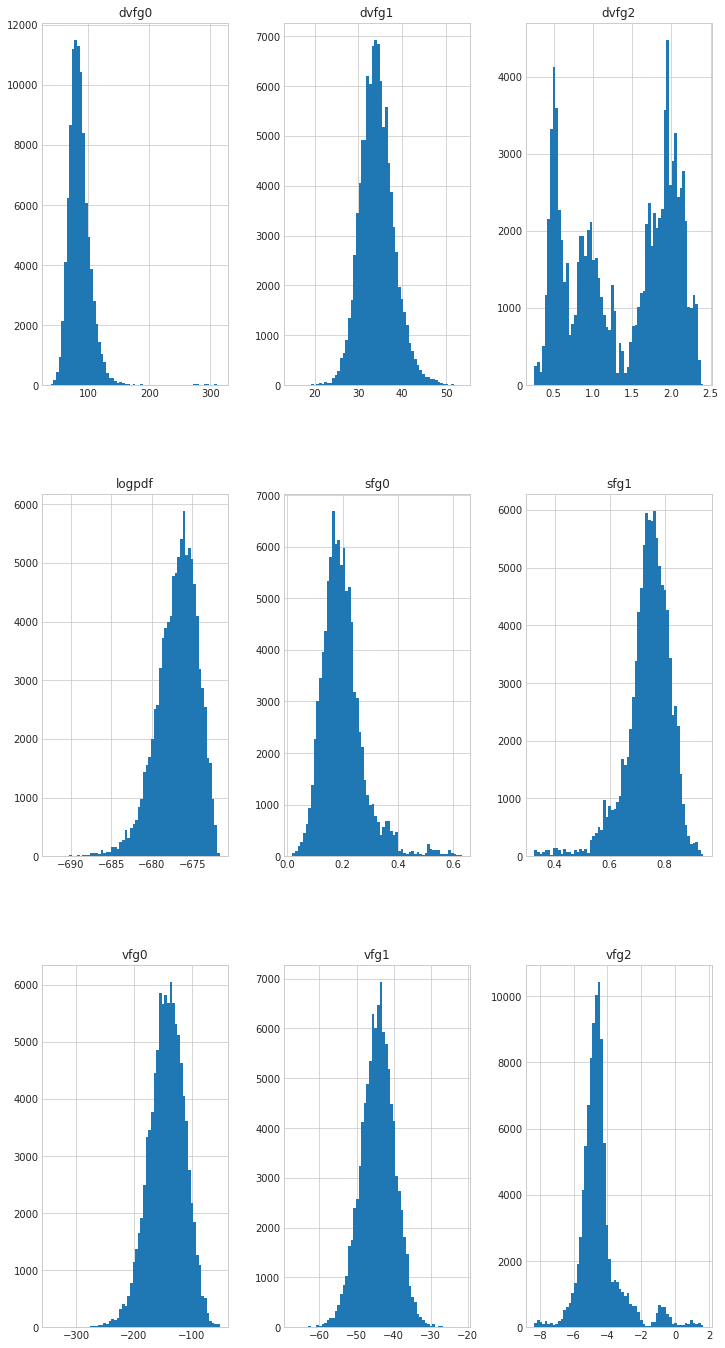

In [293]:
display(gen_cont.to_DataFrame().describe())
gen_cont.to_DataFrame().hist(bins=64,figsize=(12,24))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78528a9198>,
      dtype=object)

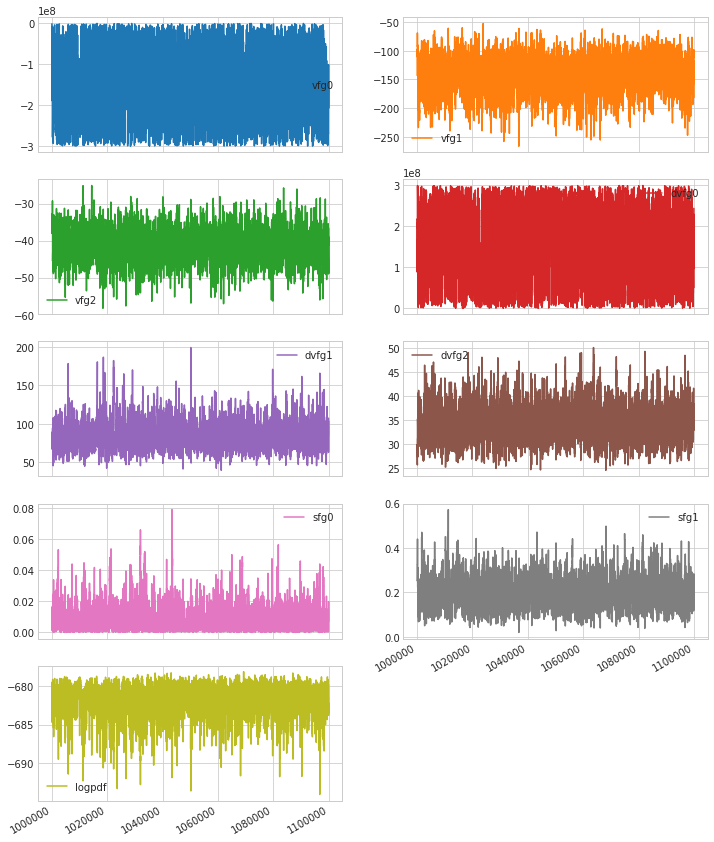

In [344]:
gen_cont.to_DataFrame()[1000000:].plot(subplots=True,figsize=(12,16),layout=(5,2))

In [369]:
argmax_full = gen_cont.to_DataFrame().sort_values(by="logpdf").iloc[-1]
argmax_last = gen_cont.to_DataFrame()[-100000:].sort_values(by="logpdf").iloc[-1]
display(argmax_full)
display(argmax_last)
argmax_2gaussian = argmax_last.copy()
argmax_2gaussian.sfg0 = 0
logpdf_2gaussian = loglikeli_cont(**argmax_2gaussian[:-1])
display(logpdf_2gaussian)
display(logpdf_2gaussian-argmax_2gaussian.logpdf)

vfg0     -136.303453
vfg1      -43.035090
vfg2       -4.614431
dvfg0      79.619452
dvfg1      34.021514
dvfg2       0.563076
sfg0        0.201259
sfg1        0.748665
logpdf   -671.563592
Name: 112384, dtype: float64

vfg0     -1.211323e+08
vfg1     -1.468893e+02
vfg2     -4.099918e+01
dvfg0     8.463548e+07
dvfg1     7.496235e+01
dvfg2     3.352920e+01
sfg0      1.121326e-03
sfg1      1.758627e-01
logpdf   -6.782046e+02
Name: 1069288, dtype: float64

-678.0629072486989

0.14169669182399502

Text(0.5,0,'$v_{los}$[km/s]')

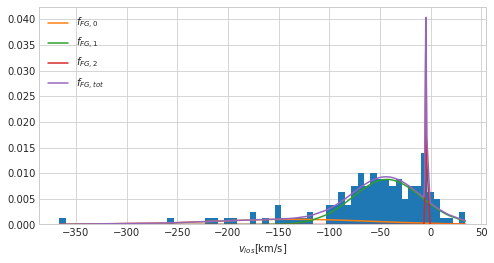

In [353]:
argmax_ = argmax[argmax.index[:-1]]
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

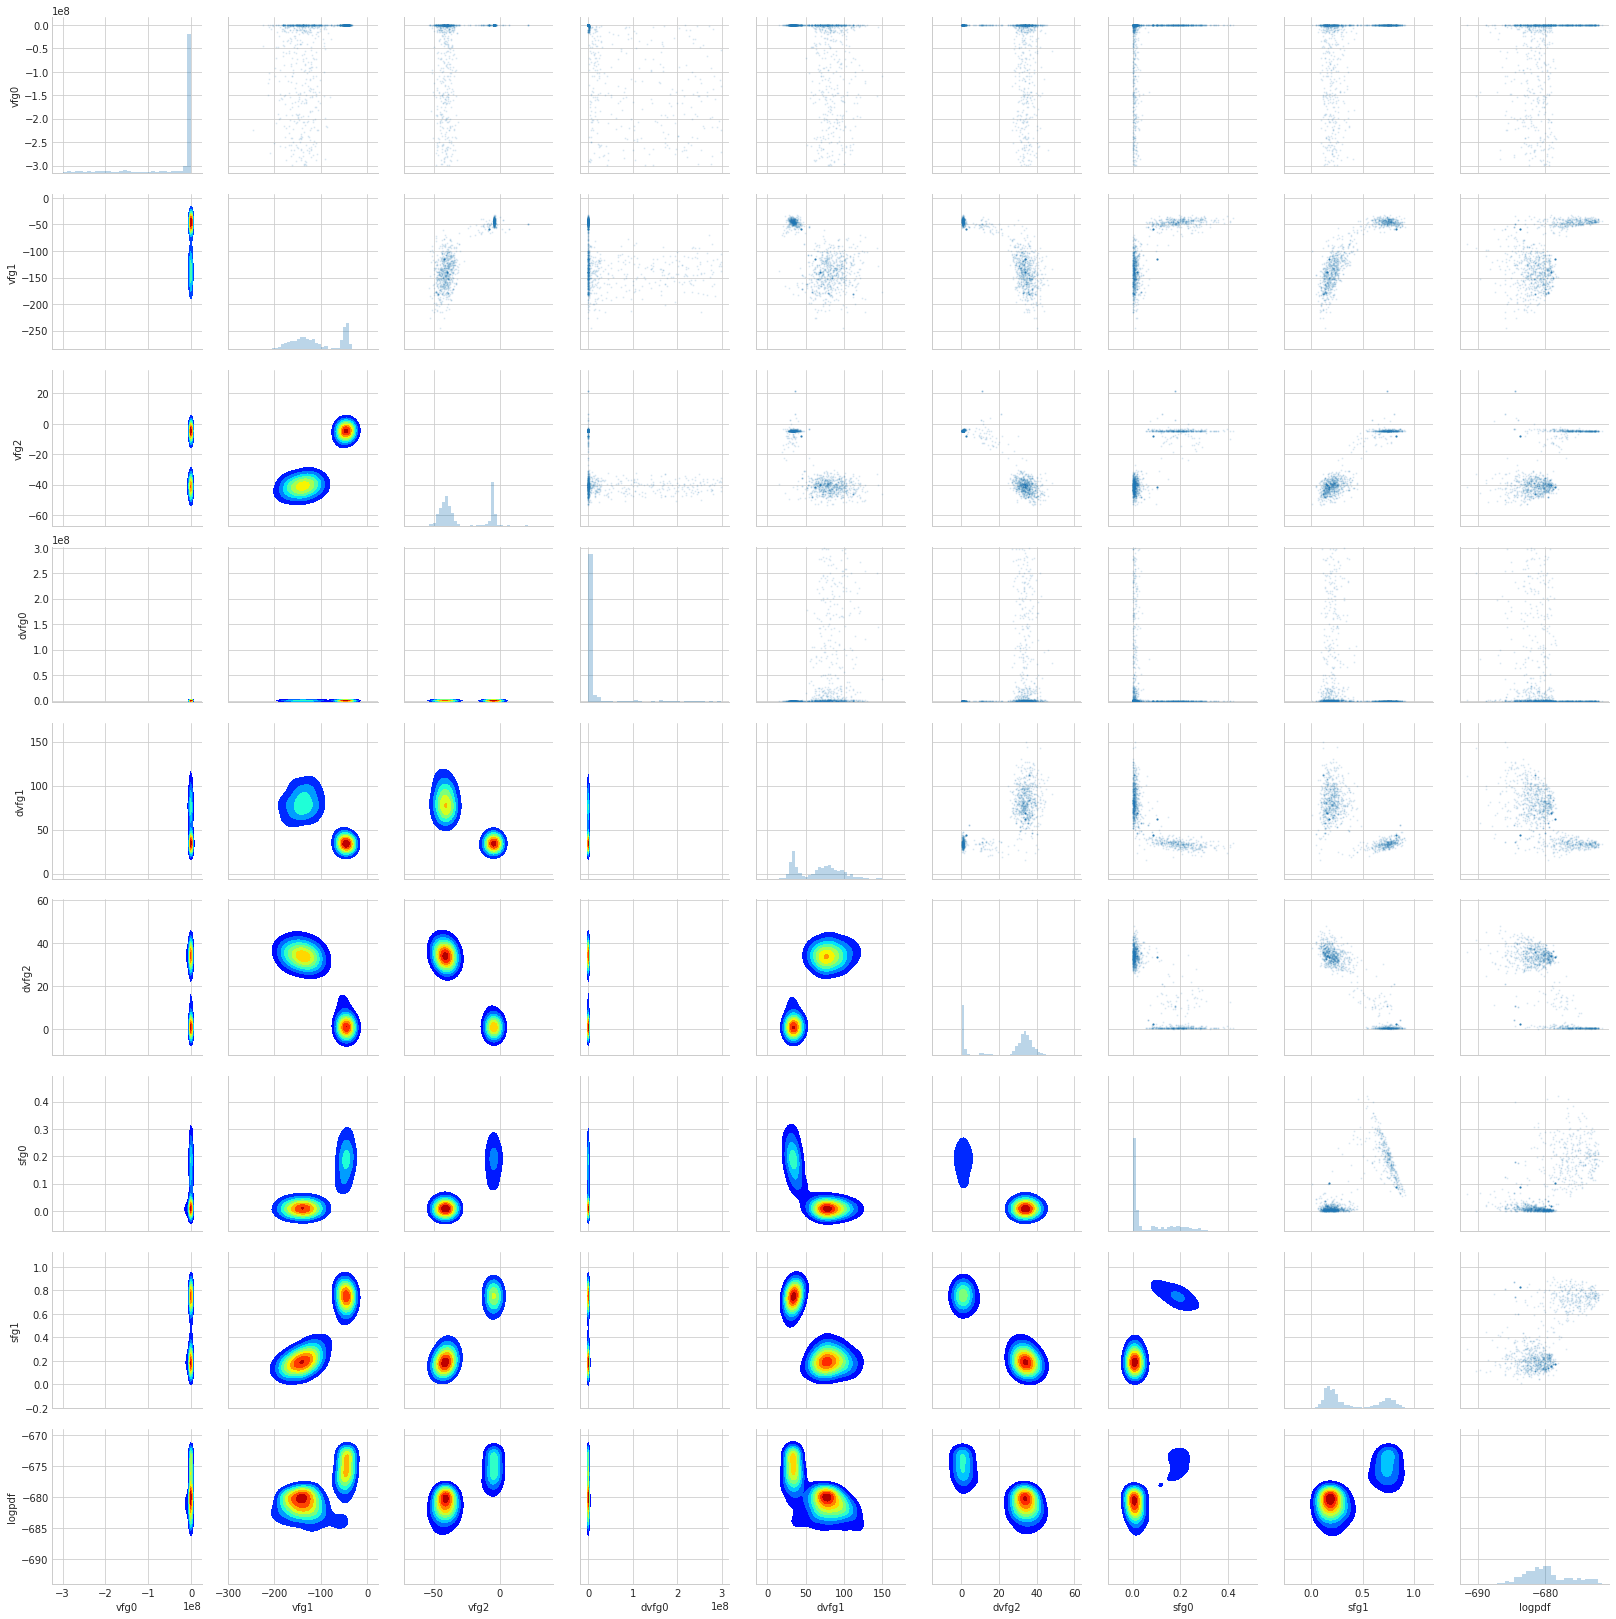

In [310]:
mypairplot(gen_cont.to_DataFrame()[::1000])

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


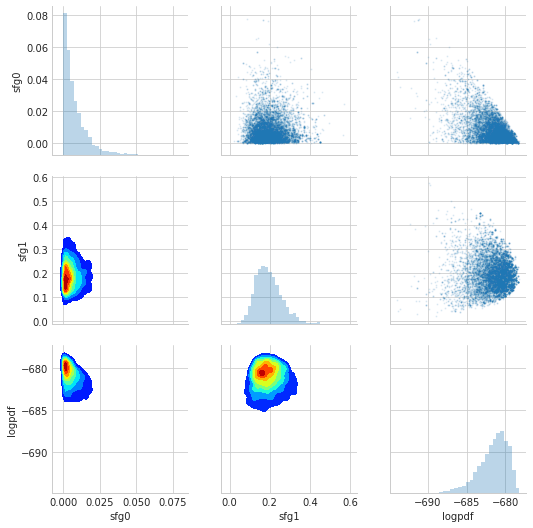

In [374]:
mypairplot(gen_cont.to_DataFrame()[-100000:][["sfg0","sfg1","logpdf"]][::10])

In [368]:
beta = 1/np.log(len(loglikeli_cont.vs))
display(1/beta)
bic_ = -gen_cont.to_DataFrame()["logpdf"].max() + (len(gen_cont.to_DataFrame().columns)-1)/2/beta
bic_

4.844187086458591

690.9403400742224

In [367]:
beta = 1/np.log(len(loglikeli_cont.vs))
bic_ = -logpdf_2gaussian + (3*2-1)/2/beta
bic_

690.1733749648454

In [314]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
#gen_cont.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION))
gen_cont.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),output_log=True)

## Sig

In [71]:
loglikeli(**{
        "re":200, "odds":6.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2., 'a':3., 'b':7., 'g':0.5, 'mlog10_1manib':0., 
        'vmem':-200, 'vfg0':-250, 'vfg1':-200, 'vfg2':-50, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.3,'sfg1':0.3
    })

-9941.263382501453

In [93]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={
        "re":200, "odds":6.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2, 'a':3, 'b':7, 'g':0.5, 'mlog10_1manib':0, 
        'vmem':-200, 'vfg0':-250, 'vfg1':-200, 'vfg2':-50, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.3,'sfg1':0.3
    },
    dargs_logpdf={
        "re":5.0,"odds":0.5,"dra0":0.01,"dde0":0.01,
        "log10_rs_pc":0.1,'log10_rhos_Msunpc3':0.1, 'a':0.1, 'b':0.1, 'g':0.1, 'mlog10_1manib':0.1, 
        'vmem':1, 'vfg0':1, 'vfg1':1, 'vfg2':2, 'dvfg0':1, 'dvfg1':1,'dvfg2':1,
        'sfg0':0.01,'sfg1':0.01
    },
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [ ]:
gen.logpdf_func.dsph.submodels["stellar_model"].cdf_R(gen.logpdf_func.Rs(0,0))

In [79]:
Nstep_init = 100
gen.generate(Nstep_init)

MCgeneration start.
options: {}
18.000% completed... acceptance rate: 0.00%
36.000% completed... acceptance rate: 0.00%
56.000% completed... acceptance rate: 0.00%
79.000% completed... acceptance rate: 0.00%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
     a    b  dde0  dra0  dvfg0  dvfg1  dvfg2    g  log10_rhos_Msunpc3  \
0  0.1  0.1  0.01  0.01    1.0    1.0    1.0  0.1                 0.1   
1  0.1  0.1  0.01  0.01    1.0    1.0    1.0  0.1                 0.1   
2  0.1  0.1  0.01  0.01    1.0    1.0    1.0  0.1                 0.1   
3  0.1  0.1  0.01  0.01    1.0    1.0    1.0  0.1                 0.1   

   log10_rs_pc  mlog10_1manib  odds   re  sfg0  sfg1  vfg0  vfg1  vfg2  vmem  \
0          0.1            0.1   0.5  5.0  0.01  0.01   1.0   1.0   2.0   1.0   
1          0.1            0.1   0.5  5.0  0.01  0.01   1.0   1.0   2.0   1.0   
2          0.1            0.1   0.5  5.0  0.01  0.01   1.0   1.0   2.0   1.0   
3          0.1            0.1   0.5  5.0  0.01 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7889915b00>,
      dtype=object)

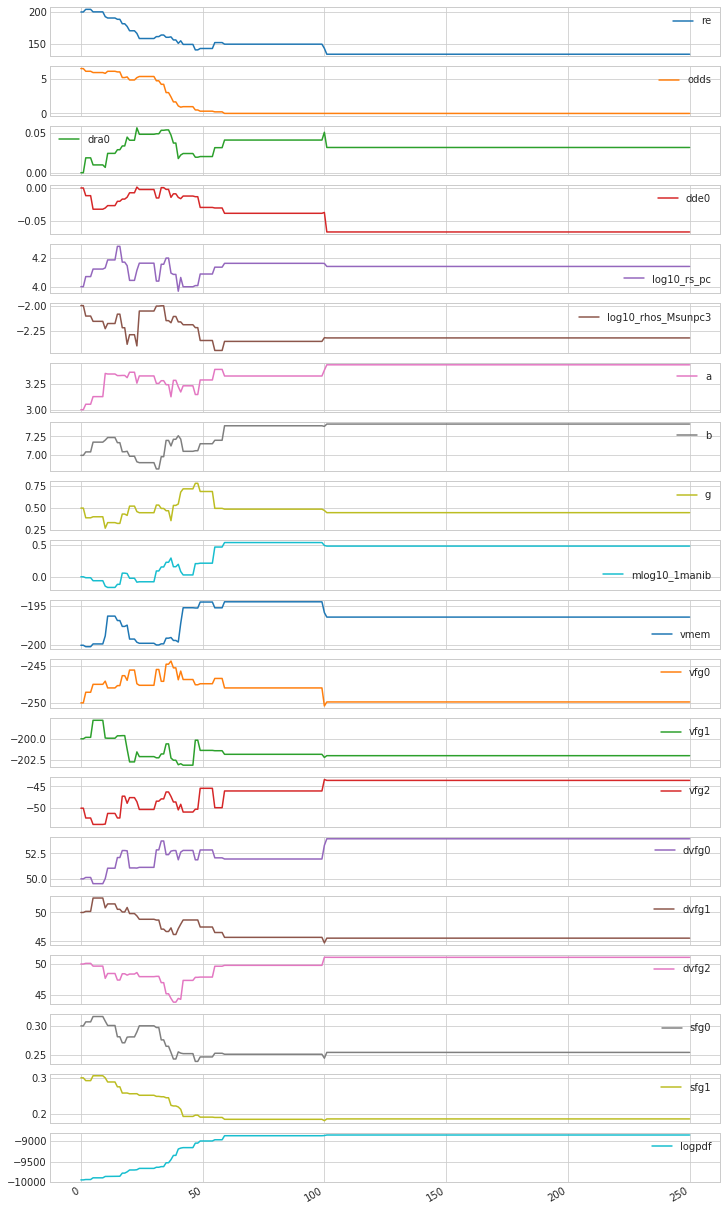

In [80]:
gen.to_DataFrame().plot(subplots=True,figsize=(12,24))

In [ ]:
gen.generate_tuned((5000,5000,5000))

In [ ]:
gen.to_DataFrame()[:].plot(subplots=True)

In [ ]:
gen.options["push_time"] = 30
gen.generate(200000)

## results

In [ ]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

if you already done the calculation, load the result below.

In [ ]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

In [ ]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

In [ ]:
mypairplot(result_df[-last_MCMC_steps::50])
#mypairplot(result_df[-lastMCMCsteps])

In [ ]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

In [ ]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

In [ ]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME
version = VERSION
result_df.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)

# WBIC calculation

In [ ]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            return np.sum(self.loglikelis(re,odds,dra0,dde0))
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [ ]:
loglikeli_wbic = KI17_loglikelihood_mod(dRAs=df_deg.x,dDEs=df_deg.y,beta=1/np.log(len(df_deg)))

In [ ]:
gen_wbic = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"n":0.8,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli_wbic
)

In [ ]:
gen_wbic.generate(5000)

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate_tuned((5000,5000,5000))

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate(100000)

In [ ]:
df_wbic = gen_wbic.to_DataFrame()[-100000:]
df_wbiclog = gen_wbic.to_DataFrame(output_log=True)
mypairplot(df_wbic[::20])

In [ ]:
wbic = -df_wbic.logpdf.mean()/loglikeli_wbic.beta
bic = -gen.to_DataFrame()[-100000:].logpdf.max() + len(gen.args_logpdf_init)/loglikeli_wbic.beta /2
print(" BIC:{}\nWBIC:{}".format(bic,wbic))

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME+"_wbic"
version = VERSION
df_wbic.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)